In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)
import warnings
warnings.filterwarnings('ignore')

2.11.0


In [4]:
# Create a list with the filepaths for training and testing
train_dir = Path(r'C:\Users\manicandone\Desktop\Fruit_Vegetable_Recognition-master/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [5]:
test_dir = Path(r'C:\Users\manicandone\Desktop\Fruit_Vegetable_Recognition-master/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [6]:
val_dir = Path(r'C:\Users\manicandone\Desktop\Fruit_Vegetable_Recognition-master/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [7]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [8]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [9]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['lemon' 'watermelon' 'sweetcorn' 'turnip' 'cucumber' 'spinach' 'grapes'
 'eggplant' 'chilli pepper' 'cabbage' 'orange' 'paprika' 'carrot'
 'capsicum' 'tomato' 'potato' 'sweetpotato' 'jalepeno' 'mango' 'peas'
 'pomegranate' 'garlic' 'corn' 'bell pepper' 'lettuce' 'onion' 'beetroot'
 'soy beans' 'raddish' 'apple' 'cauliflower' 'ginger' 'kiwi' 'banana'
 'pineapple' 'pear']


In [10]:
train_df.head(5)

,Filepath,Label
0,C:\Users\manicandone\Desktop\Fruit_Vegetable_R...,lemon
1,C:\Users\manicandone\Desktop\Fruit_Vegetable_R...,watermelon
2,C:\Users\manicandone\Desktop\Fruit_Vegetable_R...,sweetcorn
3,C:\Users\manicandone\Desktop\Fruit_Vegetable_R...,turnip
4,C:\Users\manicandone\Desktop\Fruit_Vegetable_R...,cucumber


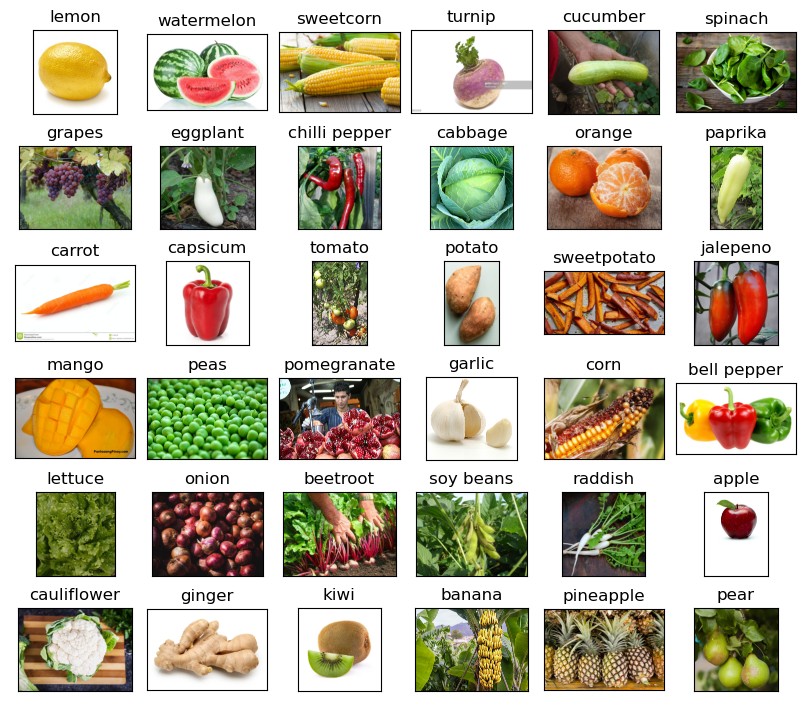

In [11]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [12]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [13]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [14]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [15]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [16]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 [==============================] - 261s 3s/step - loss: 1.7512 - accuracy: 0.5317 - val_loss: 0.4893 - val_accuracy: 0.8618
Epoch 2/5
90/90 [==============================] - 244s 3s/step - loss: 0.5852 - accuracy: 0.8186 - val_loss: 0.3183 - val_accuracy: 0.9059
Epoch 3/5
90/90 [==============================] - 256s 3s/step - loss: 0.3506 - accuracy: 0.8872 - val_loss: 0.2832 - val_accuracy: 0.9235
Epoch 4/5
90/90 [==============================] - 316s 4s/step - loss: 0.2178 - accuracy: 0.9264 - val_loss: 0.1965 - val_accuracy: 0.9529
Epoch 5/5
90/90 [==============================] - 246s 3s/step - loss: 0.1543 - accuracy: 0.9527 - val_loss: 0.1946 - val_accuracy: 0.9441


In [18]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 33s 3s/step


['cucumber',
 'soy beans',
 'banana',
 'pear',
 'apple',
 'cabbage',
 'pineapple',
 'sweetcorn',
 'onion',
 'soy beans',
 'jalepeno',
 'spinach',
 'paprika',
 'paprika',
 'onion',
 'pineapple',
 'pear',
 'kiwi',
 'mango',
 'mango',
 'bell pepper',
 'paprika',
 'watermelon',
 'ginger',
 'pineapple',
 'banana',
 'eggplant',
 'soy beans',
 'beetroot',
 'lettuce',
 'kiwi',
 'jalepeno',
 'lettuce',
 'jalepeno',
 'raddish',
 'pineapple',
 'sweetpotato',
 'turnip',
 'carrot',
 'pineapple',
 'cabbage',
 'bell pepper',
 'corn',
 'lettuce',
 'pear',
 'eggplant',
 'corn',
 'lettuce',
 'mango',
 'onion',
 'cucumber',
 'pear',
 'watermelon',
 'kiwi',
 'cauliflower',
 'watermelon',
 'beetroot',
 'sweetcorn',
 'lettuce',
 'capsicum',
 'carrot',
 'bell pepper',
 'garlic',
 'pear',
 'mango',
 'pineapple',
 'cucumber',
 'soy beans',
 'kiwi',
 'sweetcorn',
 'pear',
 'pineapple',
 'beetroot',
 'carrot',
 'turnip',
 'raddish',
 'pineapple',
 'watermelon',
 'sweetcorn',
 'orange',
 'raddish',
 'lemon',
 'gr

In [19]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [20]:
img = output(r'C:\Users\manicandone\Desktop\Fruit_Vegetable_Recognition-master/test/cabbage/Image_1.jpg')
img

1/1 [==============================] - 1s 1s/step


'cabbage'

In [21]:
model.save('FV.h5')

In [22]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install keras_preprocessing

Note: you may need to restart the kernel to use updated packages.


In [24]:
import streamlit as st
from PIL import Image
from keras_preprocessing.image import load_img, img_to_array
import numpy as np
from keras.models import load_model
import requests
from bs4 import BeautifulSoup

model = load_model('FV.h5')
labels = {0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot',
          7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger',
          14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce',
          19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple',
          26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn',
          32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}

fruits = ['Apple', 'Banana', 'Bello Pepper', 'Chilli Pepper', 'Grapes', 'Jalepeno', 'Kiwi', 'Lemon', 'Mango', 'Orange',
          'Paprika', 'Pear', 'Pineapple', 'Pomegranate', 'Watermelon']
vegetables = ['Beetroot', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Corn', 'Cucumber', 'Eggplant', 'Ginger',
              'Lettuce', 'Onion', 'Peas', 'Potato', 'Raddish', 'Soy Beans', 'Spinach', 'Sweetcorn', 'Sweetpotato',
              'Tomato', 'Turnip']


def fetch_calories(prediction):
    try:
        url = 'https://www.google.com/search?&q=calories in ' + prediction
        req = requests.get(url).text
        scrap = BeautifulSoup(req, 'html.parser')
        calories = scrap.find("div", class_="BNeawe iBp4i AP7Wnd").text
        return calories
    except Exception as e:
        st.error("Can't able to fetch the Calories")
        print(e)


def processed_img(img_path):
    img = load_img(img_path, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, [0])
    answer = model.predict(img)
    y_class = answer.argmax(axis=-1)
    print(y_class)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    print(res)
    return res.capitalize()


def run():
    st.title("Fruits🍍-Vegetable🍅 Classification")
    img_file = st.file_uploader("Choose an Image", type=["jpg", "png"])
    if img_file is not None:
        img = Image.open(img_file).resize((250, 250))
        st.image(img, use_column_width=False)
        save_image_path = r'C:\Users\manicandone\Desktop\Fruit_Vegetable_Recognition-master/test/' + img_file.name
        with open(save_image_path, "wb") as f:
            f.write(img_file.getbuffer())

        # if st.button("Predict"):
        if img_file is not None:
            result = processed_img(save_image_path)
            print(result)
            if result in vegetables:
                st.info('**Category : Vegetables**')
            else:
                st.info('**Category : Fruit**')
            st.success("**Predicted : " + result + '**')
            cal = fetch_calories(result)
            if cal:
                st.warning('**' + cal + '(100 grams)**')


run()


2023-03-02 11:38:44.568 
  command:

    streamlit run C:\Users\manicandone\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
